In [1]:
!pip install opendatasets --upgrade

In [17]:
import opendatasets as od
dataset_url = "https://drive.google.com/file/d/1ickQgC_oFq3dP3J76fRsB0esRGFaTRN_/view?usp=drive_link"
od.download(dataset_url)

19757155it [00:00, 1310054766.34it/s]


Downloaded and unzipped to  .\UK_Electricity_Demand_2009-2023


In [18]:
import pandas as pd
df = pd.read_csv("UK_Electricity_Demand_2009-2023/historic_demand_2009_2023.csv", index_col=0)

# Change column names to lower case and drop id (row number)
df.columns = df.columns.str.lower()

# Take only date and electricity demand columns
df2 = df[['settlement_date', 'settlement_period', 'england_wales_demand']]

# Sort values by date
df2 = df2.sort_values(
    by=["settlement_date", "settlement_period"], ignore_index=True
)

# Drop rows where settlement_period value is greater than 48
df2 = df2.drop(index=df2[df2["settlement_period"] > 48].index)

df2 = df2.reset_index(drop=True)

In [19]:
# Check for NaN values
df2.isna().any()

settlement_date         False
settlement_period       False
england_wales_demand    False
dtype: bool

In [20]:
# Drop settlement_period column
df3 = df2[['settlement_date', 'england_wales_demand']]

In [21]:
# Calculate the daily averages
k = 48 # Define the value of k which is the number of rows to average, since there are 48 measurements per day
df3 = df3.groupby(df3.index // k).agg({'settlement_date': 'first', 'england_wales_demand': 'mean'})

In [22]:
df3

,settlement_date,england_wales_demand
0,2009-01-01,33527.729167
1,2009-01-02,36087.083333
2,2009-01-03,35530.187500
3,2009-01-04,35889.770833
4,2009-01-05,41006.854167
...,...,...
5449,2023-12-03,31415.145833
5450,2023-12-04,31938.395833
5451,2023-12-05,32238.958333
5452,2023-12-06,31422.062500


In [23]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

   ---------------------------------------- 0.0/60.3 kB ? eta -:--:--
   --------------------------------- ------ 51.2/60.3 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 60.3/60.3 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
   ---------------------------------------- 57.5/57.5 kB 3.1 MB/s eta 0:00:00


In [24]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
# take weather for urban cities with largest population in England (London, Birmingham, Manchester) and Wales (Cardiff, Swansea)
params = {
	"latitude": [51.5085, 52.4814, 53.4809, 51.48, 51.6208],
	"longitude": [-0.1257, -1.8998, -2.2374, -3.18, -3.9432],
	"start_date": "2009-01-01",
	"end_date": "2023-12-07",
	"daily": ["temperature_2m_mean", "sunshine_duration", "precipitation_sum", "precipitation_hours", "wind_speed_10m_max"]
}
responses = openmeteo.weather_api(url, params=params)

In [25]:
# Process first location. Add a for-loop for multiple locations or weather models
weather_dfs = {}
for i, response in enumerate(responses):
  print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
  print(f"Elevation {response.Elevation()} m asl")
  print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
  print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

  # Process daily data. The order of variables needs to be the same as requested.
  daily = response.Daily()
  daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
  daily_sunshine_duration = daily.Variables(1).ValuesAsNumpy()
  daily_precipitation_sum = daily.Variables(2).ValuesAsNumpy()
  daily_precipitation_hours = daily.Variables(3).ValuesAsNumpy()
  daily_wind_speed_10m_max = daily.Variables(4).ValuesAsNumpy()

  daily_data = {"date": pd.date_range(
    start = pd.to_datetime(daily.Time(), unit = "s"),
    end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
    freq = pd.Timedelta(seconds = daily.Interval()),
    inclusive = "left"
  )}
  daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
  daily_data["sunshine_duration"] = daily_sunshine_duration
  daily_data["precipitation_sum"] = daily_precipitation_sum
  daily_data["precipitation_hours"] = daily_precipitation_hours
  daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max

  weather_dfs[i] = pd.DataFrame(data = daily_data)

Coordinates 51.49384689331055°E -0.16302490234375°N
Elevation 23.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 52.478031158447266°E -1.84014892578125°N
Elevation 151.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 53.46221160888672°E -2.232818603515625°N
Elevation 48.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 51.49384689331055°E -3.2608642578125°N
Elevation 17.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 51.63444519042969°E -3.927276611328125°N
Elevation 19.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [26]:
for key, weather_df in weather_dfs.items():
  weather_dfs[key] = weather_df.drop('date', axis=1)

weather_df = pd.concat(weather_dfs.values()).groupby(level=0).mean()

In [27]:
weather_df

,temperature_2m_mean,sunshine_duration,precipitation_sum,precipitation_hours,wind_speed_10m_max
0,-0.909717,13247.744141,0.000000,0.000000,12.922569
1,0.794867,21326.273438,0.000000,0.000000,16.436434
2,-0.980133,22530.511719,0.000000,0.000000,14.343750
3,-0.389300,3503.359863,0.000000,0.000000,12.134109
4,0.167367,22396.291016,0.600000,2.000000,22.092697
...,...,...,...,...,...
5449,4.116700,1029.600830,10.760000,16.799999,19.022980
5450,5.467534,0.000000,15.300000,16.799999,23.029873
5451,3.772533,10336.167969,3.040000,8.200000,16.716038
5452,2.434617,14383.872070,1.560000,3.400000,22.205179


In [56]:
combined_df = pd.concat([df3, weather_df], axis=1)

In [57]:
combined_df

,settlement_date,england_wales_demand,temperature_2m_mean,sunshine_duration,precipitation_sum,precipitation_hours,wind_speed_10m_max
0,2009-01-01,33527.729167,-0.909717,13247.744141,0.000000,0.000000,12.922569
1,2009-01-02,36087.083333,0.794867,21326.273438,0.000000,0.000000,16.436434
2,2009-01-03,35530.187500,-0.980133,22530.511719,0.000000,0.000000,14.343750
3,2009-01-04,35889.770833,-0.389300,3503.359863,0.000000,0.000000,12.134109
4,2009-01-05,41006.854167,0.167367,22396.291016,0.600000,2.000000,22.092697
...,...,...,...,...,...,...,...
5449,2023-12-03,31415.145833,4.116700,1029.600830,10.760000,16.799999,19.022980
5450,2023-12-04,31938.395833,5.467534,0.000000,15.300000,16.799999,23.029873
5451,2023-12-05,32238.958333,3.772533,10336.167969,3.040000,8.200000,16.716038
5452,2023-12-06,31422.062500,2.434617,14383.872070,1.560000,3.400000,22.205179


In [58]:
final_df = combined_df.copy()
final_df = combined_df.drop(['settlement_date'], axis=1)

In [59]:
final_df

,england_wales_demand,temperature_2m_mean,sunshine_duration,precipitation_sum,precipitation_hours,wind_speed_10m_max
0,33527.729167,-0.909717,13247.744141,0.000000,0.000000,12.922569
1,36087.083333,0.794867,21326.273438,0.000000,0.000000,16.436434
2,35530.187500,-0.980133,22530.511719,0.000000,0.000000,14.343750
3,35889.770833,-0.389300,3503.359863,0.000000,0.000000,12.134109
4,41006.854167,0.167367,22396.291016,0.600000,2.000000,22.092697
...,...,...,...,...,...,...
5449,31415.145833,4.116700,1029.600830,10.760000,16.799999,19.022980
5450,31938.395833,5.467534,0.000000,15.300000,16.799999,23.029873
5451,32238.958333,3.772533,10336.167969,3.040000,8.200000,16.716038
5452,31422.062500,2.434617,14383.872070,1.560000,3.400000,22.205179


<Axes: title={'center': 'England Wales Demand'}, xlabel='settlement_date'>

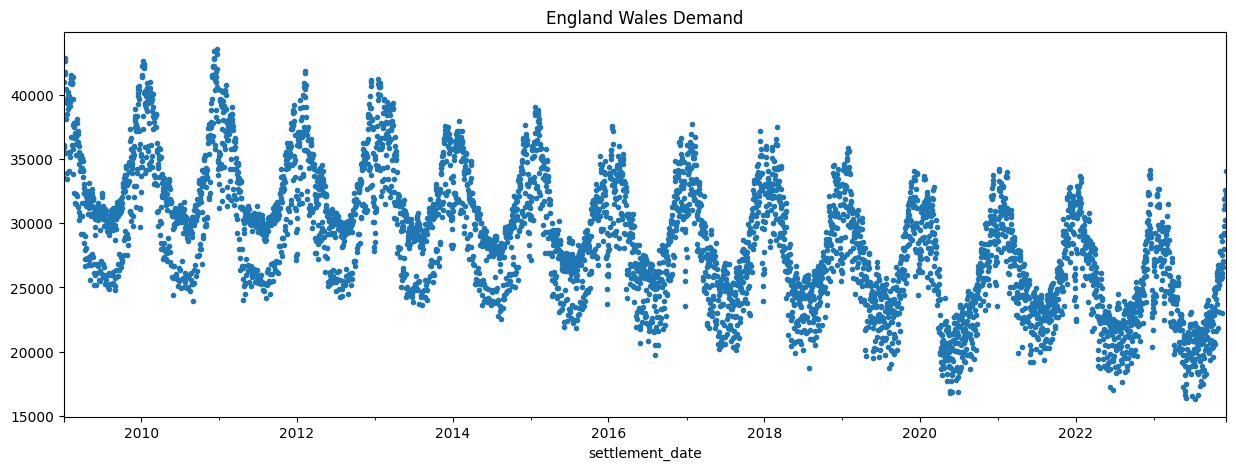

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set date as the index and turn into datetime type
df_plot = combined_df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["england_wales_demand"].plot(
    style=".", ax=ax, title="England Wales Demand", label="Timeries data"
)


# Exploratory Data Analysis (EDA) our Electricity Demand dataset
Let's look at the distribution and range of values for the 7 different features

- temperature_2m_mean
- sunshine_duration
- precipitation_sum
- precipitation_hours
- wind_speed_10m_max

and the target variable is england_wales_demand.


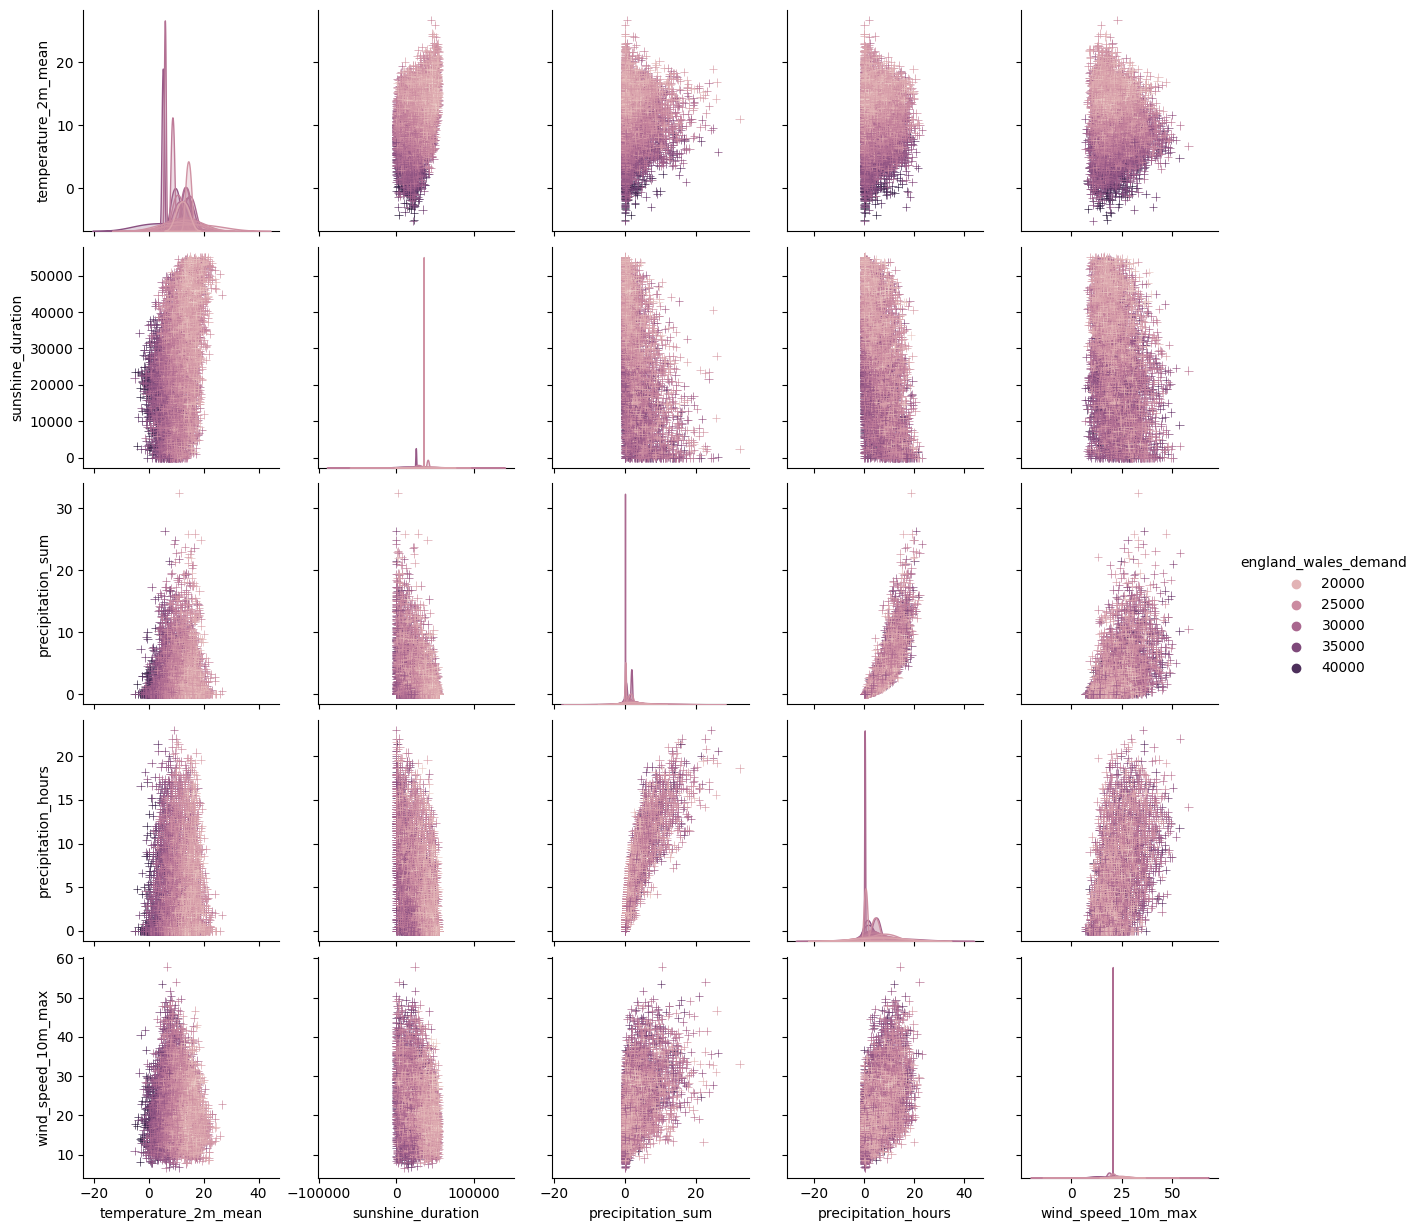

In [15]:
g = sns.pairplot(combined_df, hue='england_wales_demand', markers='+')
plt.show()

In [30]:
!pip install hopsworks --upgrade

In [39]:
import hopsworks
project = hopsworks.login(project="ID2223_Erland", api_key_value="C2R2Wdb6eGk2QiE5.2RtRxDgL8g7Agn0prIjzzqCsxJTOETQuRGImX432yIOawxKcb4Pkt8e1CLcqhj4O")

fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/361623
Connected. Call `.close()` to terminate connection gracefully.


In [63]:
weather_fg = fs.get_or_create_feature_group(
    name="weather",
    version=1,
    primary_key=["temperature_2m_mean",	"sunshine_duration",	"precipitation_sum",	"precipitation_hours",	"wind_speed_10m_max"],
    description="England/Wales weather dataset for time period 2009-2023")
weather_fg.insert(final_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/361623/fs/357446/fg/393561


Uploading Dataframe: 0.00% |          | Rows 0/5454 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: weather_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/361623/jobs/named/weather_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x182aea60450>, None)